In [1]:
using Plots, Colors, ColorSchemes, Statistics, CSV, DataFrames, JLD2, CUDA
Plots.default(fontfamily="Computer Modern")
include("src/HPMC.jl")

Main.HPMC

In [2]:
katic_means = Vector{Float32}(undef, 0)
katic_stds = Vector{Float32}(undef, 0)
ps_file = Vector{Float32}(undef, 0)
ps = round.(exp.(range(log(10), log(200), length=50)), digits=1)
for p in ps
    filepath = "data/4gon$(p)p.jld2"
    if isfile(filepath)
        katics = Vector{Float32}(undef, HPMC.framecount(filepath))
        for frame in eachindex(katics)
            particles = HPMC.RegularPolygons(
                HPMC.RegularPolygonsSnapshot(filepath, frame), gpu=true)
            katics[frame] = mean(abs.(HPMC.katic_order(particles, 4)))
        end
        push!(katic_means, mean(katics))
        push!(katic_stds, std(katics))
        push!(ps_file, p)
    end
end
df = DataFrame(:pressure => ps_file, :katic => katic_means, :error => katic_stds)
CSV.write("data/katic4gon.csv", df)

"data/katic4gon.csv"

In [11]:
for d in collect(0.0:0.5:4.0)
    df = DataFrame(CSV.File("data/runs/katic4gon4.0r$(d)d1.csv"))
    ps = df.pressure

    katics = Matrix{Float32}(undef, 10, 0)
    for run in 1:8
        df = DataFrame(CSV.File("data/runs/katic4gon4.0r$(d)d$run.csv"))
        katics = hcat(katics, df.katic[1:10])
    end
    katic_means = vec(mean(katics, dims=2))
    katic_stds = vec(std(katics, dims=2))

    katics = Matrix{Float32}(undef, 10, 0)
    for run in 1:8
        df = DataFrame(CSV.File("data/runs/katic4gon4.0r$(d)d$run.csv"))
        katics = hcat(katics, df.katic[11:end])
    end
    for run in 9:11
        df = DataFrame(CSV.File("data/runs/katic4gon4.0r$(d)d$run.csv"))
        katics = hcat(katics, df.katic)
    end
    katic_means = vcat(katic_means, vec(mean(katics, dims=2)))
    katic_stds = vcat(katic_stds, vec(std(katics, dims=2)))

    df = DataFrame(:pressure => ps, :katic => katic_means, :error => katic_stds)
    CSV.write("data/katic4gon4.0r$(d)d.csv", df)
end

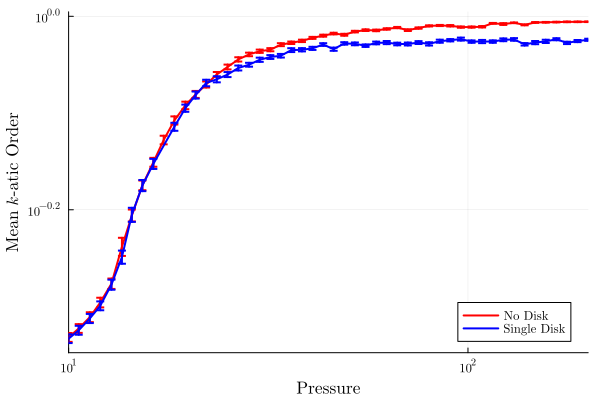

In [15]:
df = DataFrame(CSV.File("data/katic4gon.csv"))
dfdisk = DataFrame(CSV.File("data/katic4gon4.0r.csv"))
p = plot(df.pressure, df.katic, yerr=df.error, xaxis=:log, yaxis=:log,
    xlim=(10, 200), label="No Disk", lw=2, color=:red, msc=:red,
    xlabel="Pressure", ylabel="Mean \$k\$-atic Order")
plot!(p, dfdisk.pressure, dfdisk.katic, yerr=dfdisk.error,
    label="Single Disk", lw=2, color=:blue, msc=:blue)
display(p)

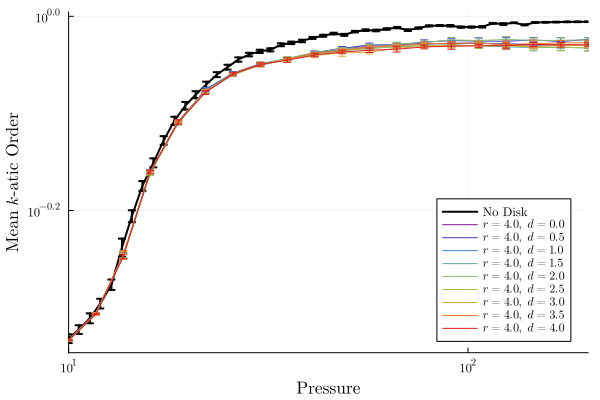

In [12]:
df = DataFrame(CSV.File("data/katic4gon.csv"))
p = plot(df.pressure, df.katic, yerr=df.error,
    label="No Disk", lw=2, xaxis=:log, yaxis=:log,
    color=:black, msc=:black, xlabel="Pressure", ylabel="Mean \$k\$-atic Order",
    xlim=(10, 200))
for d in collect(0.0:0.5:4.0)
    df = DataFrame(CSV.File("data/katic4gon4.0r$(d)d.csv"))
    linecolor = get(ColorSchemes.rainbow, d / 4.0)
    plot!(p, df.pressure, df.katic, lw=1, yerr=df.error,
        color=linecolor, msc=linecolor, label="\$r = 4.0,\\ d = $d\$")
end
display(p)

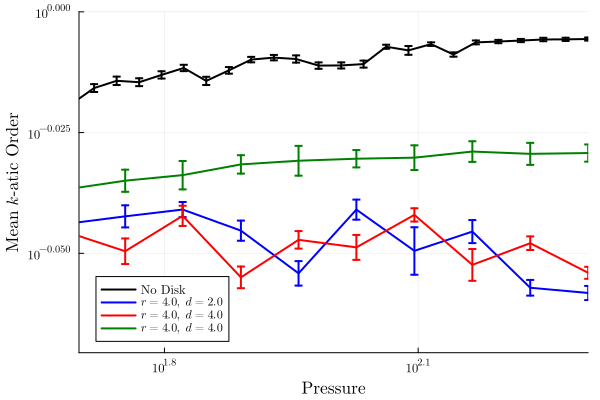

In [13]:
df = DataFrame(CSV.File("data/katic4gon.csv"))
p = plot(df.pressure, df.katic, yerr=df.error, xaxis=:log, yaxis=:log,
    label="No Disk", lw=2, color=:black, msc=:black,
    xlabel="Pressure", ylabel="Mean \$k\$-atic Order",
    xlim=(50, 200), ylim=(0.85, 1.0))
df = DataFrame(CSV.File("data/bad/katic4gon4.0r2.0d9.csv"))
plot!(p, df.pressure, df.katic, yerr=df.error, lw=2,
    color=:blue, msc=:blue, label="\$r = 4.0,\\ d = 2.0\$")
df = DataFrame(CSV.File("data/bad/katic4gon4.0r4.0d9.csv"))
plot!(p, df.pressure, df.katic, yerr=df.error, lw=2,
    color=:red, msc=:red, label="\$r = 4.0,\\ d = 4.0\$")
df = DataFrame(CSV.File("data/katic4gon4.0r4.0d.csv"))
plot!(p, df.pressure, df.katic, yerr=df.error, lw=2,
    color=:green, msc=:green, label="\$r = 4.0,\\ d = 4.0\$")
display(p)

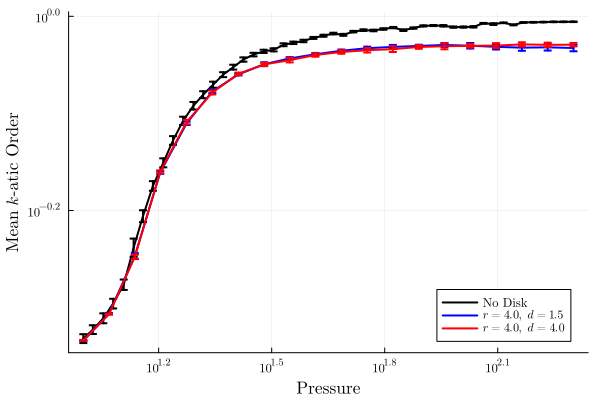

In [15]:
df = DataFrame(CSV.File("data/katic4gon.csv"))
p = plot(df.pressure, df.katic, yerr=df.error, xaxis=:log, yaxis=:log,
    label="No Disk", lw=2, color=:black, msc=:black,
    xlabel="Pressure", ylabel="Mean \$k\$-atic Order")
df = DataFrame(CSV.File("data/katic4gon4.0r1.5d.csv"))
plot!(p, df.pressure, df.katic, yerr=df.error, lw=2,
    color=:blue, msc=:blue, label="\$r = 4.0,\\ d = 1.5\$")
df = DataFrame(CSV.File("data/katic4gon4.0r4.0d.csv"))
plot!(p, df.pressure, df.katic, yerr=df.error, lw=2,
    color=:red, msc=:red, label="\$r = 4.0,\\ d = 4.0\$")
display(p)

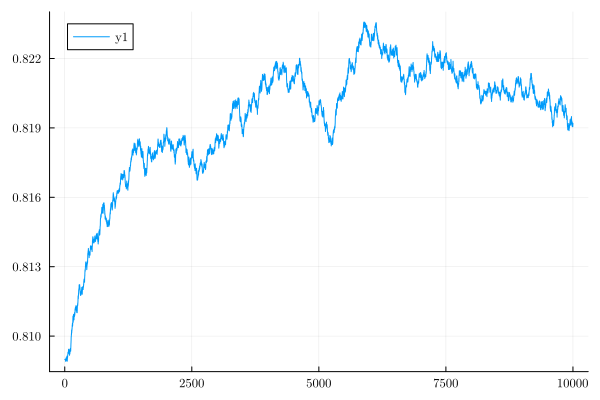

0.82002574


In [2]:
filepath = "data/test.jld2"
areas = Vector{Float32}(undef, HPMC.framecount(filepath))
jldopen(filepath) do f
    for i in 1:HPMC.framecount(filepath)
        areas[i] = prod(f["frame$i/boxsize"])
    end
end
p = plot(2000 ./ areas)
println(2000 / mean(areas[end-1000+1:end]))
display(p)

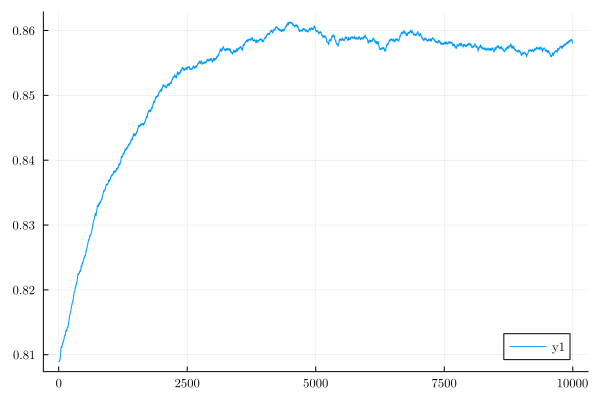

0.8570952


In [3]:
filepath = "data/test1.jld2"
areas = Vector{Float32}(undef, HPMC.framecount(filepath))
jldopen(filepath) do f
    for i in 1:HPMC.framecount(filepath)
        areas[i] = prod(f["frame$i/boxsize"])
    end
end
p = plot(2000 ./ areas)
println(2000 / mean(areas[end-1000+1:end]))
display(p)

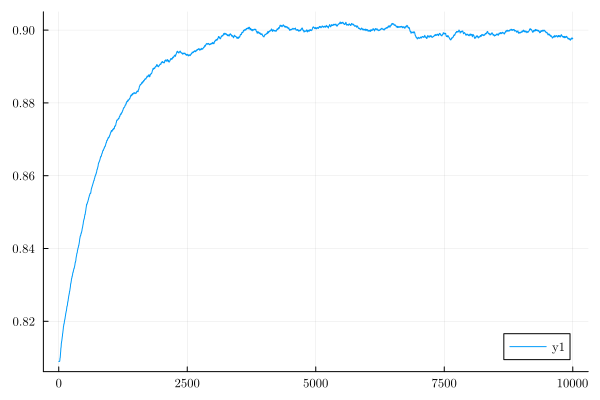

0.8989622


In [3]:
filepath = "data/test2.jld2"
areas = Vector{Float32}(undef, HPMC.framecount(filepath))
jldopen(filepath) do f
    for i in 1:HPMC.framecount(filepath)
        areas[i] = prod(f["frame$i/boxsize"])
    end
end
p = plot(2000 ./ areas)
println(2000 / mean(areas[end-1000+1:end]))
display(p)

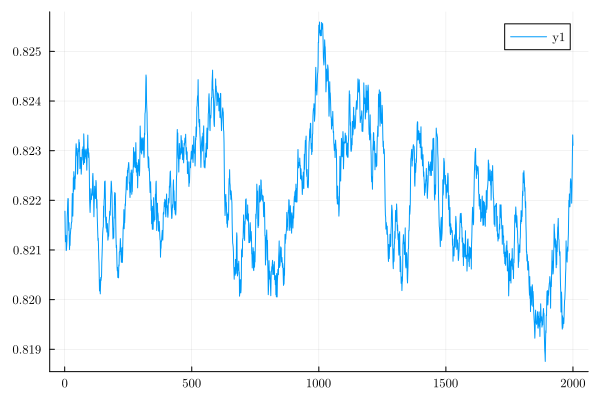

0.8220729


In [4]:
filepath = "data/raw/4gon25.0p.jld2"
areas = Vector{Float32}(undef, HPMC.framecount(filepath))
jldopen(filepath) do f
    for i in 1:HPMC.framecount(filepath)
        areas[i] = prod(f["frame$i/boxsize"])
    end
end
p = plot(2000 ./ areas)
println(2000 / mean(areas))
display(p)

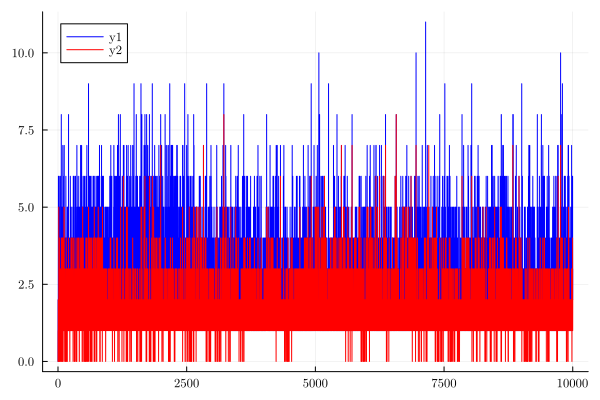

In [2]:
filepath = "data/test3.jld2"
overlaps_cpu = Vector{Int}(undef, HPMC.framecount(filepath))
for i in eachindex(overlaps_cpu)
    particles = HPMC.RegularPolygons(HPMC.RegularPolygonsSnapshot(filepath, i))
    overlaps_cpu[i] = HPMC.count_overlaps(particles, HPMC.SeqCellList(particles))
end
overlaps_gpu = Vector{Int}(undef, HPMC.framecount(filepath))
for i in eachindex(overlaps_gpu)
    particles = HPMC.RegularPolygons(HPMC.RegularPolygonsSnapshot(filepath, i), gpu=true)
    overlaps_gpu[i] = HPMC.count_overlaps(particles, HPMC.CuCellList(particles))
end
p = plot(overlaps_cpu, color=:blue)
plot!(p, overlaps_gpu, color=:red)
display(p)

In [3]:
sortperm(overlaps_cpu)

10000-element Vector{Int64}:
    1
    4
   10
   11
   16
   17
   19
   20
   21
   22
    ⋮
 5256
 7515
 8037
 9009
 9799
 5068
 6956
 9764
 7142